# Music Analysis

## Initialization and Loading the Audio Data

In [1]:
import wave
import pyaudio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
audio_file = "ThatchedVillagers.wav"

with wave.open(audio_file, "rb") as wf:
    waveform = np.frombuffer(
        wf.readframes(wf.getnframes()), dtype=np.int16
    )
    framerate = wf.getframerate()
    nchannels = wf.getnchannels()
    nframes = wf.getnframes()
    sampwidth = wf.getsampwidth()

waveform = waveform.astype(np.float32) / 32768.0
print(f"{wf.getparams()}")
print(f"{waveform=}")
print(f"{framerate=}")
print(f"{nchannels=}")
print(f"{nframes=}")
print(f"{sampwidth=}")

_wave_params(nchannels=2, sampwidth=2, framerate=48000, nframes=11813199, comptype='NONE', compname='not compressed')
waveform=array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
        9.1552734e-05,  6.1035156e-05, -9.1552734e-05], dtype=float32)
framerate=48000
nchannels=2
nframes=11813199
sampwidth=2


In [3]:
def play_waveform(waveform, sample_rate=44100, seconds=1):
    "Plays one second of audio from the given waveform, expects mono input"
    p = pyaudio.PyAudio()
    # Open a stream
    stream = p.open(format=pyaudio.paFloat32, channels=1, rate=sample_rate, output=True)
    # Play the waveform
    stream.write(waveform[:sample_rate*seconds].tobytes())
    # Close the stream
    stream.stop_stream()
    stream.close()
    # Terminate PyAudio
    p.terminate()

In [4]:
print(len(waveform))        # The waveform contains this many samples
print(nframes * nchannels)  # Each frame contains `nchannels` samples, so the total number of samples is this

23626398
23626398


11813199 11813199


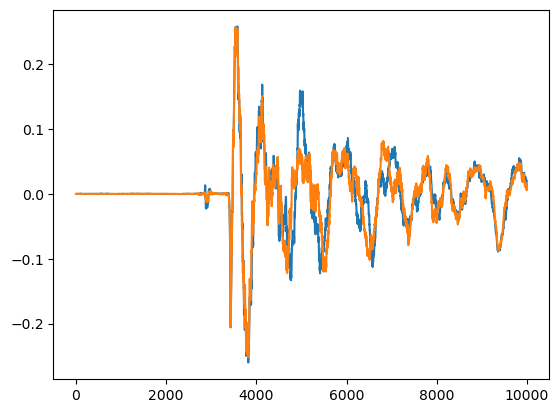

In [5]:
samples_l = waveform[::2]
samples_r = waveform[1::2]
plt.plot(samples_l[:10000])
plt.plot(samples_r[:10000])
print(len(samples_l), len(samples_r))

In [6]:
samples_m = (samples_l + samples_r) / 2.0
samples_d = (samples_l - samples_r) / 2.0

## Frequencies

In [7]:
t = np.linspace(0, nframes / framerate, nframes)
print("Total length of audio: %d seconds =  %dm %0.2fs" % (t[-1], t[-1] // 60, t[-1] % 60))

Total length of audio: 246 seconds =  4m 6.11s


In [8]:
frequencies = np.fft.fftfreq(len(t), 1 / framerate)
print(frequencies)
print(1/frequencies[1])
print(max(frequencies))

[ 0.          0.00406325  0.0081265  ... -0.01218975 -0.0081265
 -0.00406325]
246.10831249999998
23999.99796837419


In [9]:
# Typical piano frequencies
A4 = 440     # A above Middle C (C4), 440 Hz
A3 = A4 / 2
A2 = A3 / 2
A1 = A2 / 2
A0 = A1 / 2  # Lowest note on standard Piano
C4 = A3 * (2**(1/12.))**3
C5 = C4 * 2
C6 = C5 * 2
C7 = C6 * 2
C8 = C7 * 2
print(f"{A0=}\n{A1=}\n{A2=}\n{A3=}\n\t{C4=}\n{A4=}\n\t{C5=}\n\t{C6=}\n\t{C7=}\n\t{C8=}")

A0=27.5
A1=55.0
A2=110.0
A3=220.0
	C4=261.6255653005987
A4=440
	C5=523.2511306011974
	C6=1046.5022612023947
	C7=2093.0045224047894
	C8=4186.009044809579


Humans can listen to sounds of mostly 20 Hz - 20k Hz. That is why the sampling
frequency is almost 2x24Hz, which means the highest frequency that can be
recorded is about 24Hz (Nyquist theorem or something).

But even in this range, music would typically have frequencies within 27Hz to
5000Hz which is the range of a typical piano.

Now, to detect a frequency difference of 10Hz, we need a signal that is at least
1/10 = 0.1 seconds long.

In [10]:
pianokey_frequencies = []
key_names = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']
freq_key = {}
key_freq = {}
for i in range(88):
    name = key_names[i % len(key_names)] + str((i + 9)// len(key_names))
    freq = (2 ** (1 / 12.0)) ** i * A0
    pianokey_frequencies += [freq]
    freq_key[freq] = name
    key_freq[name] = freq

In [184]:
# Find out which frequencies fit into which buckets
bucket_size = 10   # Hz
time_step = 1/bucket_size # s
print(f"{time_step=}")
ranges = [
    (i, i + bucket_size) for i in range(0, 5000, bucket_size)
]

# Initialize a dictionary to store the keys
piano_keys = {start: [] for start, end in ranges}

# Count the keys in each range
for key in freq_key.keys():
    for start, end in ranges:
        if start <= key < end:
            piano_keys[start] += [freq_key[key]]
            break

piano_keys

time_step=0.1


{0: [],
 10: [],
 20: ['A0', 'A#0'],
 30: ['B0', 'C1', 'C#1', 'D1', 'D#1'],
 40: ['E1', 'F1', 'F#1', 'G1'],
 50: ['G#1', 'A1', 'A#1'],
 60: ['B1', 'C2', 'C#2'],
 70: ['D2', 'D#2'],
 80: ['E2', 'F2'],
 90: ['F#2', 'G2'],
 100: ['G#2'],
 110: ['A2', 'A#2'],
 120: ['B2'],
 130: ['C3', 'C#3'],
 140: ['D3'],
 150: ['D#3'],
 160: ['E3'],
 170: ['F3'],
 180: ['F#3'],
 190: ['G3'],
 200: ['G#3'],
 210: [],
 220: ['A3'],
 230: ['A#3'],
 240: ['B3'],
 250: [],
 260: ['C4'],
 270: ['C#4'],
 280: [],
 290: ['D4'],
 300: [],
 310: ['D#4'],
 320: ['E4'],
 330: [],
 340: ['F4'],
 350: [],
 360: ['F#4'],
 370: [],
 380: [],
 390: ['G4'],
 400: [],
 410: ['G#4'],
 420: [],
 430: [],
 440: ['A4'],
 450: [],
 460: ['A#4'],
 470: [],
 480: [],
 490: ['B4'],
 500: [],
 510: [],
 520: ['C5'],
 530: [],
 540: [],
 550: ['C#5'],
 560: [],
 570: [],
 580: ['D5'],
 590: [],
 600: [],
 610: [],
 620: ['D#5'],
 630: [],
 640: [],
 650: ['E5'],
 660: [],
 670: [],
 680: [],
 690: ['F5'],
 700: [],
 710: [],
 720: 

In [12]:
key_freq["C4"], key_freq["C#4"], key_freq["C#4"] - key_freq["C4"]

(261.6255653005991, 277.1826309768726, 15.55706567627351)

In [13]:
key_freq["A0"], key_freq["A#4"], key_freq["A#0"] - key_freq["A0"]

(27.5, 466.1637615180909, 1.6352350948806205)

In [14]:
1 / (key_freq["A#0"] - key_freq["A0"])

0.6115328634583913

Wow! It turns out that a 0.05 second sample (1/20 sec) is not even enough to differentiate between middle C and C#! This wasn't what I expected...

So if we want to differentiate between two signals with a frequency difference of 1 Hz, we would need at least 1 second of data. And if the minimum frequency resolution we want is 2Hz then we can use 0.5 seconds of data. But how many seconds is good enough for distinguishing musical notes?

I don't really know how fast musical notes can actually change... but let's just say maybe we can analyse the lower notes at a slower pace than the higher notes. Anyway let's go ahead and see what we can figure out from the music.

## Applying FFT

In [68]:
segment_len = int(framerate / 10)
segment_len

4800

In [69]:
frequencies = np.fft.fftfreq(segment_len, 1 / framerate)
print(list(frequencies))
print(1 / frequencies[1])
print(max(frequencies))

[0.0, 10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0, 110.0, 120.0, 130.0, 140.0, 150.0, 160.0, 170.0, 180.0, 190.0, 200.0, 210.0, 220.0, 230.0, 240.0, 250.0, 260.0, 270.0, 280.0, 290.0, 300.0, 310.0, 320.0, 330.0, 340.0, 350.0, 360.0, 370.0, 380.0, 390.0, 400.0, 410.0, 420.0, 430.0, 440.0, 450.0, 460.0, 470.0, 480.0, 490.0, 500.0, 510.0, 520.0, 530.0, 540.0, 550.0, 560.0, 570.0, 580.0, 590.0, 600.0, 610.0, 620.0, 630.0, 640.0, 650.0, 660.0, 670.0, 680.0, 690.0, 700.0, 710.0, 720.0, 730.0, 740.0, 750.0, 760.0, 770.0, 780.0, 790.0, 800.0, 810.0, 820.0, 830.0, 840.0, 850.0, 860.0, 870.0, 880.0, 890.0, 900.0, 910.0, 920.0, 930.0, 940.0, 950.0, 960.0, 970.0, 980.0, 990.0, 1000.0, 1010.0, 1020.0, 1030.0, 1040.0, 1050.0, 1060.0, 1070.0, 1080.0, 1090.0, 1100.0, 1110.0, 1120.0, 1130.0, 1140.0, 1150.0, 1160.0, 1170.0, 1180.0, 1190.0, 1200.0, 1210.0, 1220.0, 1230.0, 1240.0, 1250.0, 1260.0, 1270.0, 1280.0, 1290.0, 1300.0, 1310.0, 1320.0, 1330.0, 1340.0, 1350.0, 1360.0, 1370.0, 1380.0

In [178]:
def detect_peaks(fft):
    peaks = []
    window_len = 5
    threshold = 10
    for i in range(1,len(fft)-1):
        left_max = np.max(fft_[max(0, i - window_len) : i])
        right_max = np.max(fft_[i+1 : min(len(fft), i + window_len)])
        if left_max + threshold < fft[i] > right_max + threshold:
            peaks += [i]
    return peaks

In [179]:
amplitude = []
spectogram = []
peaks = []

for i in range(nframes // segment_len):
    segment = samples_m[i * segment_len : (i+1) * segment_len]
    fft_ = np.fft.fft(segment)
    fft_ = np.abs(fft_)
    fft_ = fft_[:500]  # Cut it off to 5000 Hz
    amplitude += [fft_.mean()]
    peaks += [frequencies[detect_peaks(fft_)]]
    # fft_ = np.log(fft_)
    spectogram.append(fft_)

spectogram = np.stack(spectogram)
print(spectogram.shape)

(2461, 500)


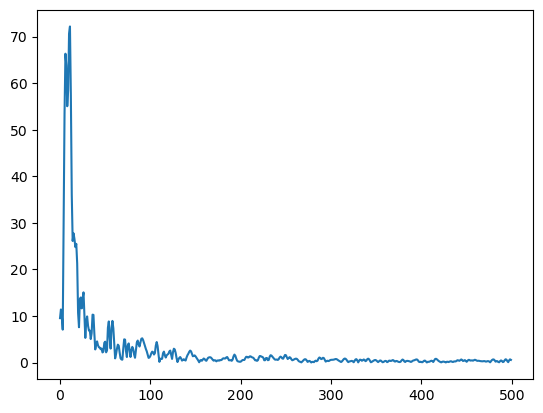

In [180]:
plt.plot(spectogram[0])

In [187]:
keyboard_roll = np.zeros((88, len(spectogram)))

for i in range(len(spectogram)):
    for freq in peaks[i]:
        keys = piano_keys[int(freq)]
        if len(keys) == 1:
            print(keys[0], end=' ')
    print()





A4 A5 A6 
A3 A4 A5 
A4 



A3 A5 
D#3 A3 A4 A5 
A3 A4 

D#3 A4 
D#3 D4 A4 
A4 
A3 A4 A5 
A3 A4 

A3 
A3 A4 
A3 A4 
A3 A4 A5 
A3 A4 A5 
A3 A4 
C4 A4 
C4 
G#3 C4 
C4 C5 
G#3 


G#2 G#3 
G#2 G#3 
G#2 G3 
A3 
G#3 

C4 C5 
C4 C5 F#5 
C4 
C4 
G#3 C4 


G#2 G#3 
G#2 G#3 
G#2 G#3 
G#3 G#6 
G3 
G#3 
D#3 D4 
D#3 D4 
D#3 D4 
D#3 A3 A4 A5 
A3 A4 
A4 
G#2 


A3 
A3 A4 A5 
A3 A4 

D#3 A4 
D#3 A4 
A5 
A3 A4 A5 
A3 A4 

A#3 


A3 A4 A5 
A3 A4 A5 
D3 A3 A4 

C#4 
C4 

G#3 G#6 
G3 
G#3 
G#2 G#3 
G#2 G#3 
G#2 G3 
G#3 

G#3 
G#2 G#3 C4 F#5 
C4 E5 
C4 
C4 
G#3 C#4 


D#3 A4 
D#3 A4 A5 
D#3 
A4 A5 
A3 D4 A4 A5 

D#3 A3 
D#3 
D#3 A4 
A3 A4 
A3 A4 
A4 

E5 

D#3 A#3 A5 
A#3 A4 A5 
A3 A4 

D#3 
D#3 A4 
D#3 
D#3 A3 A4 A5 
A3 A4 
A4 
F#3 A5 


A3 A4 
A3 A4 A5 
A3 A4 
C4 
C#4 F#5 
C4 

G#3 


G#2 G#3 
G#2 G#3 
G#2 G#3 
G#3 
G#3 

C4 C5 
C4 
C4 
C4 


G#3 
G#3 F#5 
G#2 G#3 
G#2 G3 
G#3 G#6 
G#3 

D#3 
D#3 D4 
D#3 A4 
A3 A4 
A3 A4 A5 
A3 A4 



F#4 A4 
A#3 A4 A5 
D3 A3 A4 

D#3 A3 
D#3 F#5 
A4 
D#3 A3 A4 A5 A6 

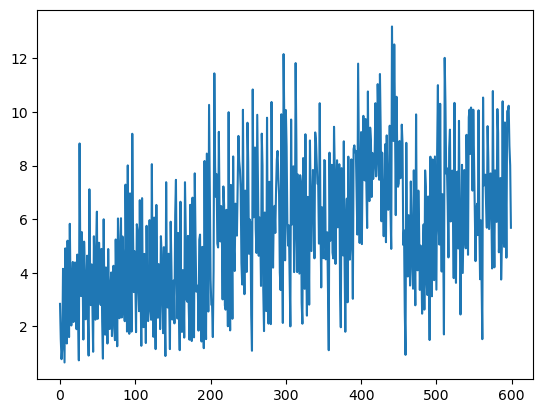

In [129]:
plt.plot(amplitude[0:600])

## Another Algorithm?

What if FFT is just _bad_ for our use case? What if we could do better with
a direct approach, just figuring out which pitch is being played simply by
searching for it directly?

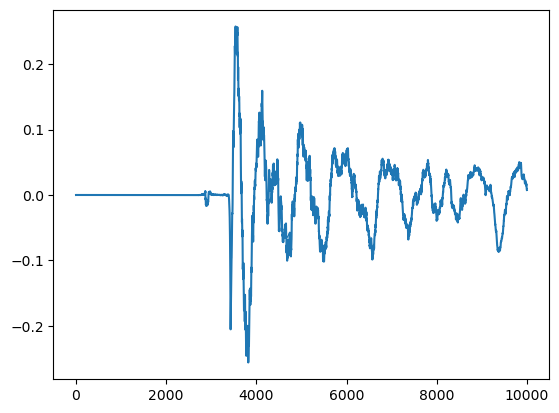

In [193]:
plt.plot(samples_m[:10000])

In [194]:
pianokey_frequencies

[27.5,
 29.13523509488062,
 30.867706328507758,
 32.703195662574835,
 34.64782887210902,
 36.708095989675954,
 38.89087296526012,
 41.203444614108754,
 43.6535289291255,
 46.249302838954314,
 48.99942949771869,
 51.91308719749317,
 55.00000000000002,
 58.27047018976127,
 61.73541265701555,
 65.4063913251497,
 69.29565774421808,
 73.41619197935194,
 77.78174593052029,
 82.40688922821755,
 87.30705785825106,
 92.49860567790869,
 97.99885899543742,
 103.82617439498638,
 110.00000000000013,
 116.54094037952261,
 123.47082531403116,
 130.81278265029945,
 138.5913154884362,
 146.83238395870396,
 155.56349186104066,
 164.8137784564352,
 174.61411571650217,
 184.99721135581746,
 195.99771799087495,
 207.65234878997288,
 220.00000000000034,
 233.0818807590453,
 246.94165062806246,
 261.6255653005991,
 277.1826309768726,
 293.6647679174081,
 311.1269837220815,
 329.62755691287055,
 349.22823143300457,
 369.99442271163514,
 391.99543598175006,
 415.304697579946,
 440.00000000000085,
 466.16376151

In [198]:
np.linspace(0, 1, 100)

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747